# Auxiliary-to-Study Tilting for Estimation of the Average Treatment Effect on the Treated (ATT)
_Bryan Graham - University of California - Berkeley_  

May 2016
<br>
<br>
#### Code citation:
<br>
Graham, Bryan S. (2016). "Auxiliary-to-Study Tilting for Estimation of the Average Treatment Effect on the Treated (ATT) Python Jupyter Notebook," (Version 1.0) [Computer program]. Available at http://bryangraham.github.io/econometrics/ (Accessed 04 May 2016)
<br>
<br>
#### Paper citation:
<br>
Graham, Bryan S., Cristine Pinto and Daniel Egel. (2016). “Efficient estimation of data combination models by the method of auxiliary-to-study tilting (AST),” _Journal of Business and Economic Statistics_ 31 (2): 288 - 301. Available at http://www.tandfonline.com/doi/abs/10.1080/07350015.2015.1038544
<br>
<br>

This notebook illustrates how to use the Python 2.7 package **ipt** to estimate the Average Treatment Effect on the Treated (ATT) estimand under exogeneity (e.g., Imbens (2004, _Review of Economics and Statistics_). This package is registered on [PyPi](https://pypi.python.org/pypi/ipt/0.2), with a GitHub repository at https://github.com/bryangraham/ipt.
<br>
<br>
The **ipt** package has the following dependencies: numpy, numpy.linalg, scipy, scipy.optimize and scipy.stats. These are standard libraries and are included in most scientific Python distributions. For example they are included in the highly recommended [Anaconda distribution of Python](https://www.continuum.io/downloads). If you are using the [Anaconda distribution of Python](https://www.continuum.io/downloads), then you can follow the (straightforward but tedious) instructions [here](http://conda.pydata.org/docs/build_tutorials/pkgs.html) to learn how install the **ipt** package from PyPi and make it available in Anaconda using the "conda" package manager. For users who anticipate only infrequent use, permanent installation of the **ipt** package may not be worth the trouble. One possibility is to just clone (ie., copy) the GitHub repository https://github.com/bryangraham/ipt, which contains the latest version of **ipt**. Then append the path pointing to the location of the ipt package on your local machine to your sys directory. This is what is done in the next snippet of code.

In [1]:
# Append location of ipt module base directory to system path
# NOTE: only required if permanent install not made (see comments above)
import sys
sys.path.append('/Users/bgraham/Dropbox/Sites/software/ipt/')

# Load ipt module
import ipt as ipt

Now load additional libraries that will be used below.

In [2]:
# Direct Python to plot all figures inline (i.e., not in a separate window)
%matplotlib inline

# Load additional libraries
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Division of two integers in Python 2.7 does not return a floating point result. The default is to round down 
# to the nearest integer. The following piece of code changes the default.
from __future__ import division

### Introducing **ipt.att()** 
The **ipt** package includes a Python 2.7 implementation of the ATT estimator introduced in Graham, Pinto and Egel (2016, _Journal of Business and Economic Statistics_). An implementation of the ATE estimator introduced in Graham, Pinto and Egel (2012, _Review of Economic Studies_) is planned for the near future.
<br>
<br>
The basic notation is as follows. $D \in \left \{ 0,1 \right \}$
is the binary treatment indicator. It equals one for treated units and zero for control units. The potential outcome under treatment is $Y$ and the potential outcome under control is $X$. This notation is admittedly non-standard but aligns with that used in the _JBES_ paper. The paper considers a more general class of data combination problems of which ATT estimation is a special case. 
<br>
<br>
The vector of always-observed pre-treatment control variables is $W$. Let $r(W)$ be a vector of known functions of $W$ such that the propensity score is a logit function with an index linear in $r(W)$. Let $\dim \left \{ r(W) \right \} = 1 + L$. The vector of known functions of $W$, $t(W)$, are those for which "exact balance" is imposed (let 
$\dim \left \{ t(W) \right \} = 1 + M$). Both $r(W)$ and $t(W)$ are assumed to contain a constant.
<br>
<br>
The treated and control units are re-weighted such that after re-weighting the mean of $t(W)$ in each of these subsamples equals its corresponding semiparametrically efficient estimate:

<div>$$\bar{t}_{\textrm{eff}} = \frac{\sum_{i=1}^{N} G(r(W_{i})'\hat{\delta}) \times t(W_{i})}
                                     { \sum_{i=1}^{N} G(r(W_{i})'\hat{\delta})}$$</div>
                        
Here $\hat{\delta}$ is the maximum likelihood estimate of the propensity score parameter and $G(v)$ is the sigmoid/logit function.
<br>
<br>
Note that in the special case where all the elements in $t(W)$ are also contained in $r(W)$, the efficient estimate $\bar{t}_{\textrm{eff}}$ is numerically identical to the sub-sample mean of $t(W)$ across treated units alone (this is a peculiarity of the the structure of the logit score vector and would not be true if, for example, the propensity score took a probit form). In this special case, _only_ the auxiliary/control units will need to be re-weighted to impose exact balance. However when $t(W)$ has at least some elements not in common with $r(W)$, then both the treatment and control subsamples will need to be re-weighted. In the typical empirical application the re-weighting of the treated units (relative to the empirical measure) tends to be quite modest, while that of the controls is more pronounced.
<br>
<br>
The various parameters needed by **att()** are listed in the function header. The function allows for survey sampling weights and clustered standard errors (although these two features have yet to be fully tested). 

In [3]:
help(ipt.att)

Help on function att in module ipt.att:

att(D, Y, r_W, t_W, study_tilt=True, rlgrz=1, c_id=None, s_wgt=None, silent=False)
    AUTHOR: Bryan S. Graham, UC - Berkeley, bgraham@econ.berkeley.edu    
    
    This function estimates the average treatment effect on the treated (ATT)
    using the "auxiliary-to-study tilting" (AST) method described by 
    Graham, Pinto and Egel (2016, Journal of Business and Economic Statistics). 
    The notation below mirrors that in the paper where possible. The Supplemental 
    Web Appendix of the paper describes the estimation algorithm implemented here 
    in detail. A copy of the paper and all supplemental appendices can be found 
    online at http://bryangraham.github.io/econometrics/
    
    INPUTS
    ------
    D         : N x 1 pandas.Series with ith element equal to 1 if ith unit in the merged
                sample is from the study population and zero if from the auxiliary
                population (i.e., D is the "treatment" indicator

For problems where overlap is poor, the "rlgrz" regularization parameter can be an important user choice. Solving for the study/treatment and auxiliary/control "tilts" involves the solution to a convex problem over restricted domain. When $\bar{t}_{eff}$ is _near_ the boundary of the convex hull of the scatter of $t(W)$ points across control units, solving for the auxiliary/control tilt can be numerically challenging and numerical underflow issues may arise. The default value of "rlgrz" (which is one) is generally sufficient for quick and reliable computation of the two tilts for most problems. For problems where overlap is poor sometimes the "rlgrz" parameter needs to be set to a smaller value to ensure that a valid solution is found. This corresponds to less regularizations, but also a harder optimization problem for the solver. Validity of the solution can be easily checked by ensuring that the balancing conditions are satisfied in practice (which are shown in the output). Note that in situations where overlap is very poor there will be _no_ valid tilt of the control/auxiliary sample. In such cases the AST estimate is undefined. My general advice is to _not_ proceed in such situations or to use parametric estimation procedures where researcher reliance on functional form assumptions is transparent. However, there are some interesting recent alternative proposals that may be worth carefully considering when overlap is poor. See for example the working paper by Athey, Imbens and Wagner (2016) on the Arxiv http://arxiv.org/abs/1604.07125.

### Illustration with NSW evaluation dataset

Following Dehejia and Wahba (1999, _Journal of American Statistical Association_) I work with the subset of the NSW evaluation dataset where _two_ pretreatment earnings levels are observed (earnings in both 1974 and 1975). Earnings in 1978, which is post-treatment, is the outcome of interest. I construct two data frames, the first is the subset of NSW participants with two years of pre-treatment earnings ($N = 445$). Of these units $185$ correspond to treated units, with the remaining $260$ being controls.
<br>
<br>
Following Dehejia and Wahba I also create an "observational" dataset consisting of the $185$ NSW treated units _and_ a set of $2,490$ non-treated control units from the PSID. These two datasets are put into the nsw and nsw_obs pandas data frames. Some basic statistics on the "observational" dataset are reported below.
<br>
<br>
These datasets can be imported into a pandas dataframe directly from Rajeev Dehejia's webpage (http://users.nber.org/~rdehejia/index.html)

In [4]:
# Read in LaLonde NSW data as DataFrame directly from Rajeev Dehejia's webpage
nsw=pd.read_stata("http://www.nber.org/~rdehejia/data/nsw_dw.dta")

# Read in LaLonde PSID pseudo-controls as DataFrame directly from Rajeev Dehejia's webpage
psid = pd.read_stata("http://www.nber.org/~rdehejia/data/psid_controls.dta") 

# Create pseudo-observational dataset of NSW treated subjects and PSID "controls"
frames = [nsw[(nsw.treat != 0)], psid]
nsw_obs = pd.concat(frames)

# Make some adjustments to variable definitions in observational dataframe
nsw_obs['constant'] = 1                    # Add constant to observational dataframe
nsw_obs['age']      = nsw_obs['age']/10    # Rescale age to be in decades

nsw_obs['re74']        = nsw_obs['re74']/1000            # Recale earnings to be in thousands
nsw_obs['re75']        = nsw_obs['re75']/1000            # Recale earnings to be in thousands
nsw_obs['re74_X_re75'] = nsw_obs['re74']*nsw_obs['re75'] # Prior earnings interaction
nsw_obs['re74_sq']     = nsw_obs['re74']**2              # Squares of prior earnings
nsw_obs['re75_sq']     = nsw_obs['re75']**2              # Squares of prior earnings

nsw_obs['ue74']        = 1*(nsw_obs['re74']==0)          # Dummy for unemployed in 1974
nsw_obs['ue75']        = 1*(nsw_obs['re75']==0)          # Dummy for unemployed in 1975
nsw_obs['ue74_X_ue75'] = nsw_obs['ue74']*nsw_obs['ue75'] # Prior unemployment interaction


nsw_obs.describe()

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78,constant,re74_X_re75,re74_sq,re75_sq,ue74,ue75,ue74_X_ue75
count,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.0,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000
mean,0.069159,3.422579,11.994392,0.291589,0.034393,0.819439,0.333084,18.229973,17.850929,20502.371094,1.0,488.345612,520.561951,511.173492,0.129346,0.134579,0.101308
std,0.253759,1.049983,3.053559,0.454579,0.182268,0.384722,0.471402,13.722255,13.877773,15632.524414,0.0,825.004883,846.587952,890.807251,0.335645,0.341338,0.301793
min,0.000000,1.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.500000,10.000000,0.000000,0.000000,1.000000,0.000000,8.816700,7.605290,9243.400879,1.0,53.216442,77.734200,57.840645,0.000000,0.000000,0.000000
50%,0.000000,3.200000,12.000000,0.000000,0.000000,1.000000,0.000000,17.437475,17.008064,19432.103516,1.0,271.637817,304.065552,289.274261,0.000000,0.000000,0.000000
75%,0.000000,4.350000,14.000000,1.000000,0.000000,1.000000,1.000000,25.470469,25.583711,28815.667969,1.0,623.526764,648.744751,654.526581,0.000000,0.000000,0.000000
max,1.000000,5.500000,17.000000,1.000000,1.000000,1.000000,1.000000,137.148682,156.653229,121173.578125,1.0,21484.783203,18809.761719,24540.234375,1.000000,1.000000,1.000000


### Experimental benchmark estimate of the ATT
A simple comparision of post-treatment earnings across NSW treated and control units provides an unbiased estimate of the ATT. Such an estimate is computed below. Treated individuals earned $1,794 more in 1978 than non-treated individuals.

In [5]:
Y = nsw['re78']
D = nsw['treat']

nsw_reg1=sm.OLS(Y,sm.add_constant(D)).fit(cov_type='HC0')
print '------------------------------------------------------------------------------'
print '- NSW Experimental Benchmark                                                 -'
print '------------------------------------------------------------------------------'
print ''
print(nsw_reg1.summary())

------------------------------------------------------------------------------
- NSW Experimental Benchmark                                                 -
------------------------------------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     7.187
Date:                Tue, 23 Aug 2016   Prob (F-statistic):            0.00762
Time:                        13:43:40   Log-Likelihood:                -4542.7
No. Observations:                 445   AIC:                             9089.
Df Residuals:                     443   BIC:                             9098.
Df Model:                           1                                         
Covariance Type:                  HC0              

### Observational estimate of the ATT using PSID controls
Next I attempt estimate the ATT using the PSID "observational" controls instead of the experimental ones. Even if we are willing to assume unconfoundedness holds in this setting, computing the ATT in this context is challenging. To show why this is the case, the next snippet of code plots the convex hull of joint empirical distribution of 1974 and 1975 earnings across the PSID controls. It also plots the mean earnings across these two years for both NSW treatment and PSID control units.
<br>
<br>
Note that mean earnings across treated units is very near the boundary of the convex hull of earnings values across control units. This means that _any re-weighting of control units that equates their mean earnings with those observed across treated units will need to place a large amount of mass on a small number of units and close to zero mass on many units._ The required tilt will be "far" from the empirical measure of the control sample. This tilt may be hard to compute.

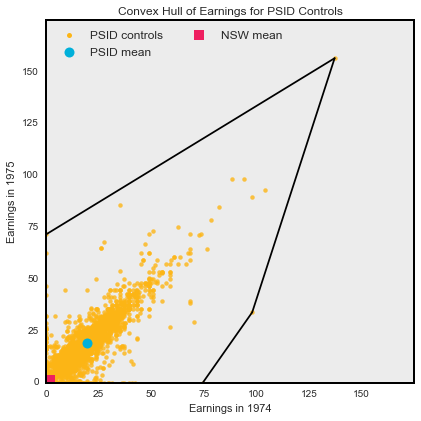

In [6]:
# Directory where figures generated below are saved
workdir =  '/Users/bgraham/Dropbox/Sites/software/ipt/Notebooks/'

from scipy.spatial import ConvexHull

# Extract pre-treatment earnings for NSW treated units and PSID controls
earnings_treatment = np.asarray(nsw_obs[(nsw_obs.treat == 1)][['re74','re75']])
earnings_control   = np.asarray(nsw_obs[(nsw_obs.treat == 0)][['re74','re75']])

# Calculate convex hull of PSID control units' earnings realizations
hull = ConvexHull(earnings_control)

# Create a figure object to plot the convex hull
convexhull_fig = plt.figure(figsize=(6, 6))    

# Scatter plot of pre-treatment earnings in 1974 and 1975 for PSID controls
ax = convexhull_fig.add_subplot(1,1,1)
sns.regplot(x="re74", y="re75", data=nsw_obs[(nsw_obs.treat == 0)], \
            fit_reg=False, color='#FDB515')
plt.title('Convex Hull of Earnings for PSID Controls', fontsize=12)
plt.xlabel('Earnings in 1974')
plt.ylabel('Earnings in 1975')

# Set plot range and tick marks
plt.ylim([0,175])
plt.xlim([0,175])    
plt.xticks([0, 25, 50, 75, 100, 125, 150], fontsize=10)
plt.yticks([0, 25, 50, 75, 100, 125, 150], fontsize=10)

# Plot mean earnings for NSW treated units and PSID controls
plt.plot(np.mean(earnings_control[:,0]), np.mean(earnings_control[:,1]), \
         color='#00B0DA', marker='o', markersize=10)
plt.plot(np.mean(earnings_treatment[:,0]), np.mean(earnings_treatment[:,1]), \
         color='#EE1F60', marker='s', markersize=10)

# Plot convex hull
for simplex in hull.simplices:
    plt.plot(earnings_control[simplex, 0], earnings_control[simplex, 1], 'k-')

# Clean up the plot, add frames, remove gridlines etc.
ax = plt.gca()
ax.patch.set_facecolor('gray')               # Color of background
ax.patch.set_alpha(0.15)                     # Translucency of background
ax.grid(False)                               # Remove gridlines from plot

# Add frame around plot
for spine in ['left','right','top','bottom']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('k')
    ax.spines[spine].set_linewidth(2)

# Add legend to the plot
import matplotlib.lines as mlines

psid_patch      = mlines.Line2D([], [], color='#FDB515', marker='o', linestyle='None',\
                                markersize=5, label='PSID controls')
psid_mean_patch = mlines.Line2D([], [], color='#00B0DA', marker='o', linestyle='None',\
                                markersize=10, label='PSID mean')
nsw_mean_patch  = mlines.Line2D([], [], color='#EE1F60', marker='s', linestyle='None',\
                                markersize=10, label='NSW mean')

lgd = plt.legend(handles=[psid_patch, psid_mean_patch, nsw_mean_patch], \
                          loc='upper left', fontsize=12, ncol=2, numpoints = 1) 
        
# Render & save plot
plt.tight_layout()
plt.savefig(workdir+'Fig_LaLonde_Convex_Hull.png')

### Computing the AST estimates of the ATT using the PSID controls
This next snippet of code computes the ATT estimate using the PSID controls. This shows how use the **ipt.att()** function. The vector $ t(W) $ is specified to include earnings in both 1974 and 1975, as well as their squares and cross product. This choice ensures exact balancing of the first two moments of the pre-treatment earnings distributions across treated and controls. I additionally include in $t(W)$ age, education and the black and hispanic dummies. I rescale some of these variables to make computation easier (which is good to do in practice). The constructed auxiliary tilt satisfies the exact balancing conditioning to (at least) four decimal places. I also set $r(W) = t(W)$

In [7]:
# Treatment indicator
D = nsw_obs['treat']

# Propensity score model
h_W = nsw_obs[['constant','black','hispanic','age','married','nodegree',\
               're74','re75','re74_X_re75','ue74','ue75','ue74_X_ue75']]

# Balancing moments
t_W = h_W

# Outcome
Y = nsw_obs['re78']

# Compute AST estimate of ATT
[gamma_ast, vcov_gamma_ast, pscore_tests, tilts, exitflag] = \
                                            ipt.att(D, Y, h_W, t_W, study_tilt = False, rlgrz = 1/2)

# Compute log of auxiliary/control sample normalized weights to construct histogram below
pi_a = tilts[:,2]               # Auxiliary tilt is the last columnn in np.array tilts
b = np.where(1-D)[0]            # find indices of control units
Na = len(pi_a[b])
log_wgts = np.log(Na*pi_a[b])   # log of normalized weights to undo right skewness for plotting purposes


--------------------------------------------------------------
- Computing propensity score by MLE                          -
--------------------------------------------------------------
Fisher-Scoring Derivative check (2-norm): 0.00831726
Value of -logL = 637.535534,  2-norm of score = 46926.447030
Value of -logL = 601.847043,  2-norm of score = 20882.930803
Value of -logL = 579.229465,  2-norm of score = 8642.278711
Value of -logL = 567.863851,  2-norm of score = 3267.708251
Value of -logL = 563.686079,  2-norm of score = 1043.374506
Value of -logL = 523.957455,  2-norm of score = 948.152593
Value of -logL = 459.353280,  2-norm of score = 712.331232
Value of -logL = 438.436638,  2-norm of score = 754.113316
Value of -logL = 424.163192,  2-norm of score = 221.810646
Value of -logL = 312.906584,  2-norm of score = 424.740914
Value of -logL = 312.673403,  2-norm of score = 109.754311
Value of -logL = 279.017837,  2-norm of score = 114.881237
Value of -logL = 236.779505,  2-norm of sc

Observe that the test of $H_{0} : \lambda_{a} = 0$ is decisively rejected. This should be unsurprising. The covariate distribution in the PSID is so different from that observed across the NSW treated units that it would be extraordinary if the p-score took a parsimonious form (recall from Graham, Pinto and Egel (2016, JBES), and work on discriminant analysis more generally, that the propensity score is related to the ratio of the covariate densities in the treated and control samples).
<br>
<br>
The ATT estimate is close to its experimental benchmark, with a somewhat larger standard error. Despite the PSID including 2,490 controls the standard error goes up relative to the experimental benchmark (which is based on a much smaller number of controls). This reflects poor overlap. 

### Experimental benchmark estimate of the ATT with covariate adjustment by AST
Next I compute the AST estimate of the ATT using the NSW experimental controls and the same specification for $t(W)$ given above. However, I set $r(W)$ to include a constant only (corresponding to the fact that we know _a priori_ that the propensity score is constant due the RCT structure of the data). Note in this case that both the study and auxiliary tilts need to be computed.

In [8]:
# Make some adjustments to variable definitions in experimental dataframe
nsw['constant'] = 1                # Add constant to observational dataframe
nsw['age']      = nsw['age']/10    # Rescale age to be in decades

nsw['re74']        = nsw['re74']/1000          # Recale earnings to be in thousands
nsw['re75']        = nsw['re75']/1000          # Recale earnings to be in thousands
nsw['re74_X_re75'] = nsw['re74']*nsw['re75']   # Prior earnings interaction
nsw['re74_sq']     = nsw['re74']**2            # Squares of prior earnings
nsw['re75_sq']     = nsw['re75']**2            # Squares of prior earnings

nsw['ue74']        = 1*(nsw['re74']==0)        # Dummy for unemployed in 1974
nsw['ue75']        = 1*(nsw['re75']==0)        # Dummy for unemployed in 1975
nsw['ue74_X_ue75'] = nsw['ue74']*nsw['ue75']   # Prior unemployment interaction


# Treatment indicator
D = nsw['treat']

# Balancing moments
t_W = nsw[['constant','black','hispanic','age','married','nodegree',\
           're74','re75','re74_X_re75','ue74','ue75','ue74_X_ue75']]

# Propensity score variables
h_W = nsw[['constant']]

# Outcome
Y = nsw['re78']

# Compute AST estimate of ATT
[gamma_ast, vcov_gamma_ast, pscore_tests, tilts, exitflag] = \
                                            ipt.att(D, Y, h_W, t_W, study_tilt = False, rlgrz = 1/2)

# Compute log of auxiliary/control sample normalized weights to construct histogram below
     
pi_a_nsw = tilts[:,2]                  # Auxiliary tilt is the last columnn in np.array tilts
b = np.where(1-D)[0]                   # find indices of control units
Na = len(pi_a_nsw[b])
log_wgts_nsw = np.log(Na*pi_a_nsw[b])  # log of normalized weights to undo right skewness for plotting purposes    


--------------------------------------------------------------
- Computing propensity score by MLE                          -
--------------------------------------------------------------
Fisher-Scoring Derivative check (2-norm): 0.00226942
Value of -logL = 302.100004,  2-norm of score = 0.000000
Value of -logL = 302.100004,  2-norm of score = 0.000000
Optimization terminated successfully.
         Current function value: 302.100004
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 4
         Hessian evaluations: 2

----------------------------------------------------------------------
- Tilt of study sample not requested by user (study_tilt = False).   -
- Validity of this requires all elements of t(W) to be elements of   -
- h(W) as well. User is advised to verify this condition.            -
----------------------------------------------------------------------


--------------------------------------------------------------
- Computing auxilia

The next snippet of code plots histograms of $N_{a} \times \pi_{a}$ for both the observational and experimental estimates. Under perfect covariate balance these normalized weights should be symmetrically centered around 1 (and tightly so in larger samples). When the PSID controls are used the distribution of these weights is very right skewed: most weights are close to zero, reflecting the fact that these units do not have any similar treated units. A small number of weights are very large (~100). This reflects the fact that, in practice, only a small number of PSID control units meaningfully contribute to the value of the ATT estimate.
<br>
<br>
We can use Leslie Kish's formula from the book _Survey Sampling_ to compute an estimate of the "effective" number of control units after re-weighting (ignoring any clustering effects). This gives

<div>$$ \textrm{Effective number of controls} = \frac{(\sum_{i=1}^{N_a} \pi_{a,i})^{2}}
                                                 { \sum_{i=1}^{N_a} \pi_{a,i}^{2}} $$</div> 

Note that the numerator sums to 1 by contruction (and hence does not need to be calculated). In the present case Kish's formula gives an effective sample size of $40$ for the PSID controls. Clearly the $2,490 $ units in the PSID are not a very good set of controls; our inferences would be just as accurate as if we instead had a random sample of units from the NSW treated population to use as controls. Kish's effective control sample size is reported in the **ipt.att()** estimation output above.

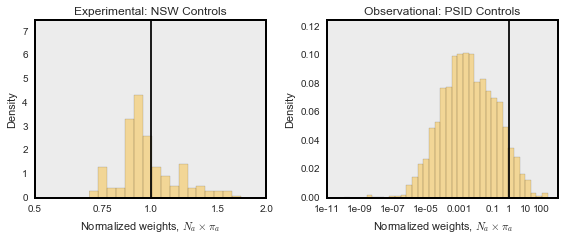

In [9]:
# Create a figure object to plot histograms of auxiliary weights
auxiliary_tilt_fig = plt.figure(figsize=(8, 3.5))    

# ------------------------------------- #
# - EXPERIMENTAL NSW CONTROLS SUBPLOT - #
# ------------------------------------- #

# Histogram of Na*pi_a (with no selection Na*pi_a should be close to one)
ax1 = auxiliary_tilt_fig.add_subplot(1,2,1)
sns.distplot(log_wgts_nsw, kde=False, color='#FDB515', norm_hist = True)
plt.plot((0, 0), (0, 7.55), 'k-') # plot vertical line at x = 1

# Set axis limits and tick marks (log scale with tick labels in levels)
plt.ylim([0,7.5])
plt.xlim(np.log([0.5,2]))

ax1.set_xticks(np.log([0.5, 0.75, 1.0, 1.5, 2.0]))
ax1.set_xticklabels([0.5, 0.75, 1.0, 1.5, 2.0])

# Add title and axis labels to histogram
plt.title('Experimental: NSW Controls', fontsize=12)
plt.xlabel("Normalized weights, " r"$N_{a} \times \pi_{a} $")
plt.ylabel('Density')

# Clean up the plot, add frames etc.
ax1 = plt.gca()
ax1.patch.set_facecolor('gray')               # Color of background
ax1.patch.set_alpha(0.15)                     # Translucency of background
ax1.grid(False)                               # Remove gridlines from plot

# Add frame around plot
for spine in ['left','right','top','bottom']:
    ax1.spines[spine].set_visible(True)
    ax1.spines[spine].set_color('k')
    ax1.spines[spine].set_linewidth(2)

# ---------------------------------------- #
# - OBSERVATIONAL PSID CONTROLS SUBPLOT  - #
# ---------------------------------------- #

# Histogram of Na*pi_a (with no selection Na*pi_a should be close to one)
ax2 = auxiliary_tilt_fig.add_subplot(1,2,2)
sns.distplot(log_wgts, kde=False, color='#FDB515', norm_hist = True)
plt.plot((0, 0), (0, 0.126), 'k-') # plot vertical line at x = 1

# Set axis limits and tick marks (log scale with tick labels in levels)
plt.ylim([0,0.125])
plt.xlim(np.log([1e-11,1000]))

ax2.set_xticks(np.log([1e-11,1e-9,1e-7,1e-5,1e-3,1e-1,1,10,100]))
ax2.set_xticklabels([1e-11,1e-9,1e-7,1e-5,1e-3,1e-1,1,10,100])

# Add title and axis labels to histogram
plt.title('Observational: PSID Controls', fontsize=12)
plt.xlabel("Normalized weights, " r"$N_{a} \times \pi_{a} $")
plt.ylabel('Density')

# Clean up the plot, add frames etc.
ax2 = plt.gca()
ax2.patch.set_facecolor('gray')               # Color of background
ax2.patch.set_alpha(0.15)                     # Translucency of background
ax2.grid(False)                               # Remove gridlines from plot

# Add frame around plot
for spine in ['left','right','top','bottom']:
    ax2.spines[spine].set_visible(True)
    ax2.spines[spine].set_color('k')
    ax2.spines[spine].set_linewidth(2)
    
# Render & save plot
plt.tight_layout()
plt.savefig(workdir+'Fig_LaLonde_Weights_Hist.png')

## Small Monte Carlo Study
The next snippet of code executes a small Monte Carlo study. It is based upon the "dense" design used in Athey, Imbens and Wagner (2016), but with the number of balancing constraints small relative to the sample size (i.e., with
$ \dim \left \{ t(W) \right \} = 1 + M $ much less than $N$). Note that in this design the propensity score is not logit with an index linear in the balancing covariates (although it is fairly well-approximated by such a model). Hence the specification test for the propensity score based on the auxiliary tilting parameters should (hopefully!) reject with frequency greater than size.
<br>
<br>
For a design with $M = 50$ and $N = 1000$ the AST procedure is computationally reliable, approximately mean and median unbiased, and produces a confidence interval with actual coverage close to target.

In [10]:
B      = 1000
N      = 1000
P      = 50

# normalize matrix to store Monte Carlo results
Simulation_Results = np.zeros((B,5))

# generate parameter vectors for covariate and outcome DGPs
delta_dense = []
beta_dense  = []
beta_harm   = []
X_names     = []

for p in range(0,P):
    delta_dense.append(4/np.sqrt(N))
    beta_dense.append(1/np.sqrt(p+1))
    X_names.append(str(p+1))

# rescale beta vector to have length 10
beta_dense =  10*(beta_dense/np.linalg.norm(beta_dense))
beta_dense = np.reshape(beta_dense,(-1,1)) # Turn into two-dimensional array, P x 1

# ------------------------------------ #
# PERFORM B MONTE CARLO REPLICATIONS - #
# ------------------------------------ #

for b in range(0,B):
    # generate treatment indicator
    W    = np.random.binomial(1, 0.5, (N,1))
    
    # generate covariate vector (with 2-cluster structure)   
    C0   = np.random.binomial(1, 0.8, (N,1))
    C1   = np.random.binomial(1, 0.2, (N,1))

    mu_X = (1 - W) * (C0 * np.zeros((1,P)) + (1 - C0) * delta_dense) \
           + W * (C1 * np.zeros((1,P)) + (1 - C1) * delta_dense) 
    X    = mu_X + np.random.multivariate_normal(np.zeros(P),np.identity(P),N)
    
    # generate outcome vector
    Y    = np.dot(X,beta_dense) + W*10 + np.random.normal(0, 1, (N,1))

    # add constant to X matrix for estimation purposes
    X    = np.concatenate((np.ones((N,1)), X), axis=1)                         
    
    # Convert W, Y and X to pandas objects
    W    = pd.Series(np.ravel(W), name="W")
    Y    = pd.Series(np.ravel(Y), name="Y")
    X    = pd.DataFrame(X)
    X.rename(columns = lambda x: str(x), inplace=True)   # Ensures column names are strings
    
    # compute AST estimate of the ATT
    try:
        [gamma_ast, vcov_gamma_ast, pscore_tests, tilts, exitflag] = \
                                                        ipt.att(W, Y, X, X, study_tilt=False, silent=True)   
         
        Simulation_Results[b,0] = (exitflag==1)           # Record whether AST computation was successful
        Simulation_Results[b,1] = gamma_ast               # Record ATT estimate
        Simulation_Results[b,2] = np.sqrt(vcov_gamma_ast) # Record standard error estimates 
            
        # Check coverage of 95 percent Wald asymptotic confidence interval
        Simulation_Results[b,3] = (gamma_ast - 1.96*Simulation_Results[b,2] <= 10) & \
                                  (gamma_ast + 1.96*Simulation_Results[b,2] >= 10)
        # Check size/power properties of auxiliary tilt specification test
        Simulation_Results[b,4] = (pscore_tests[1][2] <= 0.05)
    except:        
        Simulation_Results[b,0] = False
                     
# ------------------------------------------------ #
# - SUMMARIZE RESULTS OF MONTE CARLO SIMULATIONS - #
# ------------------------------------------------ #
        
print ""
print "Number of times AST estimate of the ATT was successfully computed"
print np.sum(Simulation_Results[:,0], axis = 0) 
                      
# find simulation replicates where computation was successful
b = np.where(Simulation_Results[:,0])[0]
SimRes = Simulation_Results[b,:]
                      
# create Pandas dataframe with AST Monte Carlo results
SR=pd.DataFrame({'ATT'      :  SimRes[:,1], 'StdErr'         :  SimRes[:,2],\
                 'Coverage' :  SimRes[:,3], 'Size of p-test' :  SimRes[:,4],})                      

print ""
print "Monte Carlo summary statistics for AST"
print SR.describe()

Q = SR[['ATT']].quantile(q=[0.05,0.95])
print ""
print 'Robust estimate of standard deviation of ATT'
print (Q['ATT'][0.95]-Q['ATT'][0.05])/(2*1.645)            


Number of times AST estimate of the ATT was successfully computed
1000.0

Monte Carlo summary statistics for AST
               ATT     Coverage  Size of p-test       StdErr
count  1000.000000  1000.000000     1000.000000  1000.000000
mean      9.998317     0.951000        0.227000     0.074133
std       0.074630     0.215976        0.419102     0.002854
min       9.787789     0.000000        0.000000     0.066011
25%       9.947216     1.000000        0.000000     0.072182
50%       9.998519     1.000000        0.000000     0.073942
75%      10.047698     1.000000        0.000000     0.075981
max      10.228240     1.000000        1.000000     0.084876

Robust estimate of standard deviation of ATT
0.0754361080313


In [11]:
# This imports an attractive notebook style from Github
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())